# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Напишите заголовок первой части проекта здесь

- Автор: Alena Tsimafeyeva
- Дата: 01.09.2025

## Цели и задачи проекта

Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят, в среднем, больше времени за чтением и прослушиванием книг в приложении Яндекс Книги, чем пользователи из Москвы.

## Описание данных

Данные из файла yandex_knigi_data.csv, с информацией об активности пользователей в приложении для чтения и прослушивания книг:
- city — название города, в котором зарегистрирован пользователь;
- puid — уникальный идентификатор пользователя;
- hours — количество часов, проведённых пользователем в сервисе.

## Содержимое проекта

- Постановка задачи и цели исследования
- Описание данных
- Предварительный анализ данных
- Проверка гипотезы
- Составление аналитической записки

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Необходимые библиотеки
from scipy import stats as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv', index_col = 0)

In [3]:
# Первые пять строк датафрейма
df.head()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [4]:
# Инфо о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 274.5+ KB


Строк: 8784

Колонок: 3

Во всех колонках одинаковое количество строк, пропусков нет.

Типы данных в столбцах корректны.

In [5]:
# Проверка на дуликаты
duplicate_puids = df[df.duplicated(subset='puid')]

# Количество дубликатов
num_duplicates = len(duplicate_puids)

print(f"Количество дубликатов пользователей: {num_duplicates}")

# Общее количество пользователей до удаления дубликатов
print(f"Общее количество пользователей до удаления дубликатов: {len(df)}")

# Удаление дубликатов
df_cleaned = df.drop_duplicates(subset='puid', keep='first')

# Количество пользователей после удаления дубликатов
print(f"Количество пользователей после удаления дубликатов: {len(df_cleaned)}")

Количество дубликатов пользователей: 244
Общее количество пользователей до удаления дубликатов: 8784
Количество пользователей после удаления дубликатов: 8540


Были выявлены и удалены 244 дубликата.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [6]:
# Данные на группы по городам
moscow_df = df_cleaned[df_cleaned['city'] == 'Москва']
spb_df = df_cleaned[df_cleaned['city'] == 'Санкт-Петербург']

# Количество пользователей в каждой группе
print(f"Количество пользователей в Москве: {len(moscow_df)}")
print(f"Количество пользователей в Санкт-Петербурге: {len(spb_df)}")

# Статистика по обеим группам
moscow_stats = moscow_df['hours'].describe()
spb_stats = spb_df['hours'].describe()

print("\nСтатистика для Москвы:")
print(moscow_stats)

print("\nСтатистика для Санкт-Петербурга:")
print(spb_stats)

Количество пользователей в Москве: 6234
Количество пользователей в Санкт-Петербурге: 2306

Статистика для Москвы:
count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

Статистика для Санкт-Петербурга:
count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64


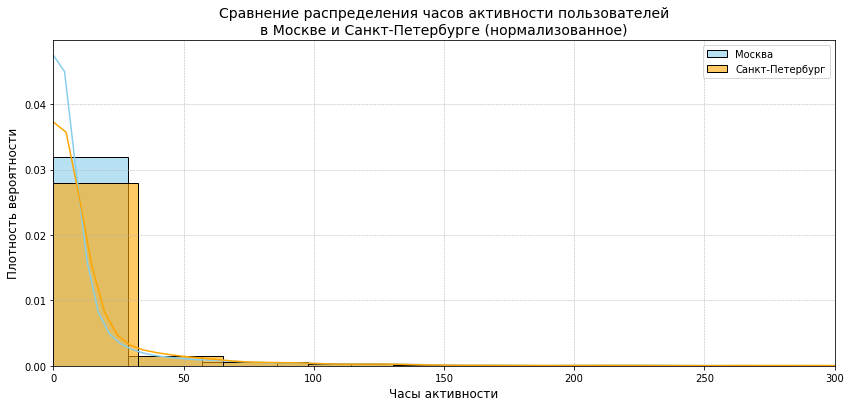

In [7]:
# Визуализация данных по группам 
plt.figure(figsize=(14, 6))

# Гистограмма с нормализацией для Москвы
sns.histplot(data=moscow_df, x='hours', bins=30, alpha=0.6, 
             label='Москва', color='skyblue', 
             stat="density", common_norm=False, kde=True)

# Гистограмма с нормализацией для Санкт-Петербурга
sns.histplot(data=spb_df, x='hours', bins=30, alpha=0.6, 
             label='Санкт-Петербург', color='orange', 
             stat="density", common_norm=False, kde=True)

plt.xlim(0, 300)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.title('Сравнение распределения часов активности пользователей\nв Москве и Санкт-Петербурге (нормализованное)', fontsize=14)
plt.xlabel('Часы активности', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend()

plt.show()

Количество пользователей: 8540 (Москва: 6234, Санкт-Петербург: 2306).

Для проверки гипотезы будет использован односторонний t-тест Уэлча для независимых выборок, т.к.:

- Выборки независимы (пользователи из разных городов).

- Тест устойчив к отклонениям от нормальности.

- Тест не требует равенства дисперсий.

Гипотезы:

Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [8]:
# T-тест для проверки гипотезы
t_statistic, p_value = st.ttest_ind(spb_df['hours'], moscow_df['hours'], equal_var=False, alternative='greater')

# Уровень значимости (стандартный уровень)
alpha = 0.05

# Результаты t-теста
print(f"\nРезультаты t-теста:")
print(f"t-статистика: {t_statistic:.4f}")
print(f"p-значение: {p_value:.4f}")

# Интерпретация
if p_value < alpha:
    print(f"Нулевая гипотеза отклоняется. Значительное различие в активности в пользу Санкт-Петербурга (p={p_value:.4f}).")
else:
    print(f"Нулевая гипотеза принимается. Недостаточное доказательство различия в активности пользователей (p={p_value:.4f}).")


Результаты t-теста:
t-статистика: 0.4028
p-значение: 0.3436
Нулевая гипотеза принимается. Недостаточное доказательство различия в активности пользователей (p=0.3436).


Статистический анализ не выявил значимых различий в активности пользователей между Москвой и Санкт-Петербургом (p = 0,3436). Нулевая гипотеза об одинаковом среднем времени использования приложения принимается.

## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



----

1. Метод статистического анализа.

Для проверки гипотезы был применен односторонний t-тест Уэлча для независимых выборок с уровнем значимости α = 0,05.

2. Результаты теста.

- t-статистика: 0,4028

- p-value: 0,3436

3. Статистический вывод.

Поскольку полученное p-value (0,3436) превышает установленный уровень значимости (α = 0,05), нулевая гипотеза не отвергается. Статистически значимых различий в среднем времени использования приложения между пользователями из Москвы и Санкт-Петербурга не выявлено.

4. Интерпретация результатов.

Отсутствие статистически значимых различий может быть связано с:

- Недостаточным объемом выборки из Санкт-Петербурга (2306 пользователей против 6234 из Москвы).

- Схожими поведенческими паттернами пользователей в двух городах.

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Целью исследования - оценка эффективности новой версии интерфейса интернет-магазина BitMotion Kit, протестированного в формате A/B-теста.

Ожидаемый эффект - увеличение количества пользователей, совершающих покупку.

## 2. Загрузите данные, оцените их целостность.


In [9]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [10]:
# Информация о данных участников теста
print('Участники:')
print(participants.info())
print(participants.head())

# Информация о данных событий
print('\nСобытия:')
print(events.info())
print(events.head())

Участники:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB
None
            user_id group                  ab_test   device
0  0002CE61FF2C4011     B        interface_eu_test      Mac
1  001064FEAAB631A1     B  recommender_system_test  Android
2  001064FEAAB631A1     A        interface_eu_test  Android
3  0010A1C096941592     A  recommender_system_test  Android
4  001E72F50D1C48FA     A        interface_eu_test      Mac

События:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  

Данные participants:
- Количество строк: 14 525.
- Столбцы: 4.
- Пропусков нет.
- Типы данных в столбцах соответсвуют.

Данные events:
- Количество строк: 787 286.
- Столбцы:4.
- Пропуски есть в столбце details, но он не является для нас значимыми.
- Типы данных в столбцах ок.

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [11]:
# Дубликаты в участниках
dups_participants = participants.duplicated().sum()
print(f"Количество дубликатов в participants: {dups_participants}")

# Дубликатоы в событиях
dups_events = events.duplicated().sum()
print(f"Количество дубликатов в events: {dups_events}")

# Удаляю дубликаты из участников
participants_cleaned = participants.drop_duplicates()

# Удаляю дубликаты из событий
events_cleaned = events.drop_duplicates()

# Количество строк после удаления дубликатов
print(f"Количество строк в participants после удаления дубликатов: {len(participants_cleaned)}")
print(f"Количество строк в events после удаления дубликатов: {len(events_cleaned)}")

Количество дубликатов в participants: 0
Количество дубликатов в events: 36318
Количество строк в participants после удаления дубликатов: 14525
Количество строк в events после удаления дубликатов: 750968


In [12]:
# Пользователи в двух тестах
crossover_check = participants_cleaned.groupby('user_id')['ab_test'].nunique()
users_in_multiple_tests = crossover_check[crossover_check > 1]

# Удаляю этих пользователей из общего списка
clean_participants = participants_cleaned[~participants_cleaned['user_id'].isin(users_in_multiple_tests.index)]

# Выделим только участников теста 'interface_eu_test'
relevant_participants = clean_participants[clean_participants['ab_test'] == 'interface_eu_test']

# Проверим распределение по группам 
group_distribution = relevant_participants['group'].value_counts().loc[['A', 'B']]
print("\nРаспределение пользователей по группам после чистки:")
print(group_distribution)

# Повторная проверка на пересечение 
crossover_check_clean = clean_participants.groupby('user_id')['ab_test'].nunique()
users_in_multiple_tests_clean = crossover_check_clean[crossover_check_clean > 1]

# Вывод по результатам проверки
if users_in_multiple_tests_clean.empty:
    print("\nПересечения между тестами после чистки: не обнаружены ")
else:
    print("\nПересечения между тестами после чистки: обнаружены ")
    print(users_in_multiple_tests_clean)


Распределение пользователей по группам после чистки:
A    4952
B    5011
Name: group, dtype: int64

Пересечения между тестами после чистки: не обнаружены 


3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [13]:
# user_id в interface_eu_test
relevant_ids = relevant_participants['user_id'].unique()

# Cобытия этих пользователей
relevant_events = events_cleaned[events_cleaned['user_id'].isin(relevant_ids)].copy()

# Результаты
print(f"Количество событий, связанных с пользователями теста 'interface_eu_test': {len(relevant_events)}")

relevant_events.head()

Количество событий, связанных с пользователями теста 'interface_eu_test': 68074


,user_id,event_dt,event_name,details
64672,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0
64946,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8
66585,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32
67873,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48
67930,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [14]:
# Дата регистрации для каждого пользователя
registrations = relevant_events[relevant_events['event_name'] == 'registration']
first_reg = registrations.groupby('user_id')['event_dt'].min().rename('registration_dt')

# Мерж к таблице событий дату регистрации
relevant_events = relevant_events.merge(first_reg, on='user_id', how='left')

# lifetime (дни)
relevant_events['lifetime_days'] = (relevant_events['event_dt'] - relevant_events['registration_dt']).dt.days

# События только за первые 7 дней
events_7_days = relevant_events[relevant_events['lifetime_days'] < 7].copy()

# Результаты
print(f"Количество событий за первые семь дней после регистрации: {len(events_7_days)}")

events_7_days.head()

Количество событий за первые семь дней после регистрации: 58692


,user_id,event_dt,event_name,details,registration_dt,lifetime_days
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,2020-12-06 14:10:01,0
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,2020-12-06 14:37:25,0
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,2020-12-06 17:20:22,0
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,2020-12-06 19:36:54,0
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,2020-12-06 19:42:20,0


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [15]:
baseline = 0.30
goal = 0.33  
alpha = 0.05
power = 0.80

# Эффект размера
effect_size = proportion_effectsize(baseline, goal)

# Расчёт необходимого размера выборки на группу
analysis = NormalIndPower()
size_for_group = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, alternative='two-sided')

print(f"Необходимое количество пользователей в каждой группе: {round(size_for_group)}")

Необходимое количество пользователей в каждой группе: 3762


Количество пользователей в группах: A - 4952 и B - 5011 — выборка достаточна для статистически значимых выводов.

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [16]:
# События с покупками
purchase_events = events_cleaned[(events_cleaned['user_id'].isin(relevant_participants['user_id'])) & 
                                 (events_cleaned['event_name'] == 'purchase')]

# Количество уникальных пользователей, сделавших покупку
buyers = purchase_events.groupby('user_id').size().reset_index()[['user_id']]
buyers = buyers.merge(relevant_participants[['user_id', 'group']], on='user_id', how='left')

# Количество покупателей по группам
buyers_count = buyers.groupby('group')['user_id'].nunique()

# Общее количество пользователей по группам
total_users = relevant_participants.groupby('group')['user_id'].nunique()

# Результаты
print("Количество пользователей, сделавших покупку, по группам:")
print(buyers_count)

print("\nОбщее количество пользователей по группам:")
print(total_users)

Количество пользователей, сделавших покупку, по группам:
group
A    1638
B    1782
Name: user_id, dtype: int64

Общее количество пользователей по группам:
group
A    4952
B    5011
Name: user_id, dtype: int64


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [17]:
# Расчет конверсии
conversion_A = (buyers_count['A'] / total_users['A']) * 100
conversion_B = (buyers_count['B'] / total_users['B']) * 100

print("Конверсия по группам:")
print(f"Группа A: {conversion_A:.2f}%")
print(f"Группа B: {conversion_B:.2f}%")
print(f"Разница: {conversion_B - conversion_A:.2f}%")

if conversion_B >= goal:
    print("Группа В достигла или превысила плановый показатель конверсии.")
else:
    print("Группа В не достигла планового показателя конверсии.")

Конверсия по группам:
Группа A: 33.08%
Группа B: 35.56%
Разница: 2.48%
Группа В достигла или превысила плановый показатель конверсии.


Проведённый A/B-тест соответствует требованиям технического задания. Данные прошли очистку и подготовку. Размеры тестовой и контрольной групп являются достаточными для выявления значимых изменений.

Предварительные результаты:

- В тестовой группе B зафиксировано 1782 пользователей, совершивших покупку.

- В контрольной группе A - 1638 пользователей с покупками.

- Полученные данные указывают на потенциально положительное влияние новой версии сайта на поведенческие метрики пользователей.

Для формирования окончательных выводов необходимо провести статистическую проверку гипотез (z-тест для пропорций) с целью подтверждения статистической значимости и исключения случайного характера улучшений.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Нулевая гипотеза H₀ Конверсия в группе B меньше или равна конверсии в группе A.

Альтернативная гипотеза H₁ Конверсия в группе B больше, чем в группе A.

Т.к. у нас две независимые выборки и двойной исход (покупка / нет), подойдет Z-тест для пропорций (двусторонний).

In [18]:
# Число пользователей, совершивших покупку, в группах B и A
buyers = [buyers_count['B'], buyers_count['A']]  # B, A

# Общее число пользователей в группах B и A
total = [total_users['B'], total_users['A']]

# Проводим односторонний Z-тест с альтернативой "B > A"
z_stat, p_value = proportions_ztest(count=buyers, nobs=total, alternative='larger')

print(f"z-статистика: {z_stat:.4f}")
print(f"p-значение: {p_value:.4f}")

z-статистика: 2.6112
p-значение: 0.0045


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

1. Статистическая значимость

Полученное p-value = 0.0045 значительно ниже стандартного уровня значимости α = 0.05.

Это означает, что вероятность случайного получения таких результатов крайне мала (менее 0,5%).

2. Отвержение нулевой гипотезы

На основании низкого p-value мы отвергаем нулевую гипотезу H₀.

Принимаем альтернативную гипотезу H₁: конверсия в группе B действительно больше, чем в группе A.

3. Эффективность изменений

Эффект достигнут: Новая версия сайта (группа B) показала статистически значимое улучшение конверсии.

4. Рекомендация

Результаты теста подтверждают эффективность новой версии сайта.

Рекомендуется внедрить изменения на всю пользовательскую базу.